 # DQN Training in Maze Environment (Hyperparameterized)

In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import datetime
import os
from collections import deque
import random
import itertools
from collections import deque


 ## Hyperparameters

In [2]:
hyperparams = {
    "learning_rate":1e-4,
    "gamma": 0.97,
    "epsilon_decay_episodes": 0.9,
    "batch_size": 256,
    "replay_buffer_size": 12000,
    "episodes": 4000,
    "hidden_layers": 
        [128, 128, 256] 
    ,
    "activation": "relu",
    "mini_exploit_runs_per_episode": 20,
    "mini_explore_runs_per_episode": 5,
    "epsilon_start": 1.0,
    "epsilon_min": 0.01,
    "replay_buffer_size": 10000,
    "steps_per_episode": 1000,
    "target_update_freq": 500,
    "random_seed": 42,
    "maze_width": 10,
    "maze_height": 10,
    "maze_imperfections": 5,
    "log_every": 200,
    "q_log_every": 2000,
    "plot_every": 1100,
    "train_after": 0.2,
    "target_dqn_update" : 30
}


# Constants

 ## Maze Setup

In [3]:
random_seed = 42
maze_width = 7
maze_height = 7


np.random.seed(random_seed)

env = maze_library.init_environment(maze_width, maze_height, mini_exploit_runs_per_episode=hyperparams["mini_exploit_runs_per_episode"], mini_explore_runs_per_episode=hyperparams["mini_explore_runs_per_episode"], use_weighted_graph=False)
maze_library.make_maze_imperfect(env)

input_shape = env.input_shape()
n_outputs = env.output_shape()


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 ## Model Definition

In [5]:
activation_map = {
    "relu": nn.ReLU,
    "elu": nn.ELU,
    "tanh": nn.Tanh,
    "sigmoid": nn.Sigmoid,
    # Add more if needed
}

class DoubleDQN(nn.Module):
    def __init__(self, input_size, output_size, device, hidden_layers=[64, 64, 64], activation="elu"):
        super(DoubleDQN, self).__init__()
        self.device = device

        # Constants
        self.visual_feature_size = 175  # 5x5x7
        self.visual_channels = 7
        self.grid_size = 5

        # Compute size of non-visual input
        self.non_visual_input_size = input_size - self.visual_feature_size

        # CNN for visual features (input shape: [batch, 7, 5, 5])
        self.cnn = nn.Sequential(
            nn.Conv2d(self.visual_channels, 32, kernel_size=3, padding=1),  # output: [batch, 32, 5, 5]
            activation_map[activation](),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # output: [batch, 64, 5, 5]
            activation_map[activation](),
            nn.MaxPool2d(2),  # output: [batch, 64, 2, 2]
        )

        # Output from CNN flattened
        cnn_output_size = 64 * 2 * 2

        # FC layers for non-visual part
        fc_input_size = cnn_output_size + self.non_visual_input_size
        self.fc_layers = nn.Sequential()
        prev_size = fc_input_size
        for i, hidden_size in enumerate(hidden_layers):
            self.fc_layers.add_module(f"fc{i}", nn.Linear(prev_size, hidden_size))
            self.fc_layers.add_module(f"act{i}", activation_map[activation]())
            prev_size = hidden_size

        # Output layer
        self.fc_layers.add_module("output", nn.Linear(prev_size, output_size))

    def forward(self, x):
        # Split input into visual and non-visual components
        visual_flat = x[:, -self.visual_feature_size:]  # Last 175 features
        non_visual = x[:, :-self.visual_feature_size]   # Remaining features

        # Reshape visual input to [batch, 7, 5, 5]
        visual = visual_flat.view(-1, self.visual_channels, self.grid_size, self.grid_size)

        # Process visual features through CNN
        visual_out = self.cnn(visual)
        visual_out = visual_out.view(visual_out.size(0), -1)  # Flatten

        # Concatenate visual and non-visual features
        x_combined = torch.cat((non_visual, visual_out), dim=1)

        # Forward through FC layers
        return self.fc_layers(x_combined)


def create_double_dqn_model(hyperprm):
    model = DoubleDQN(input_shape, n_outputs, DEVICE, hyperprm["hidden_layers"], hyperprm["activation"])
    target_model = DoubleDQN(input_shape, n_outputs, DEVICE, hyperprm["hidden_layers"], hyperprm["activation"])
    target_model.load_state_dict(model.state_dict())  # Initialize target model with the same weights
    optimizer = torch.optim.NAdam(model.parameters(), lr=5e-5)
    loss_fn = nn.MSELoss()

    return model, target_model, optimizer, loss_fn


 ## Policy and Replay Buffer

In [6]:
import numpy as np

class PrioritizedReplayBuffer:
    def __init__(self, capacity, state_shape, alpha=0.6):
        self.capacity = capacity
        self.state_shape = state_shape
        self.alpha = alpha  # prioritization exponent

        # Main buffers
        self.states = np.empty((capacity, *state_shape), dtype=np.float32)
        self.actions = np.empty((capacity,), dtype=np.int64)
        self.rewards = np.empty((capacity,), dtype=np.float32)
        self.next_states = np.empty((capacity, *state_shape), dtype=np.float32)
        self.dones = np.empty((capacity,), dtype=bool)
        self.truncateds = np.empty((capacity,), dtype=bool)

        # Priority buffer
        self.priorities = np.zeros((capacity,), dtype=np.float32)

        self.size = 0
        self.ptr = 0
        self.epsilon = 1e-6  # small value to avoid zero priority

    def append(self, state, action, reward, next_state, done, truncated):
        max_prio = self.priorities.max() if self.size > 0 else 1.0

        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state
        self.dones[self.ptr] = done
        self.truncateds[self.ptr] = truncated

        self.priorities[self.ptr] = max_prio  # assign max priority for new samples

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size, beta=0.4):
        if self.size == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.size]

        # Sampling probabilities
        probs = prios ** self.alpha
        probs /= probs.sum()

        idxs = np.random.choice(self.size, batch_size, p=probs)

        # Importance-sampling weights
        weights = (self.size * probs[idxs]) ** (-beta)
        weights /= weights.max()  # normalize for stability

        batch = dict(
            state=self.states[idxs],
            action=self.actions[idxs],
            reward=self.rewards[idxs],
            next_state=self.next_states[idxs],
            done=self.dones[idxs],
            truncated=self.truncateds[idxs],
            weights=weights,
            indices=idxs
        )

        return batch

    def update_priorities(self, indices, td_errors):
        # Use absolute TD error + small epsilon to avoid zero priorities
        self.priorities[indices] = np.abs(td_errors) + self.epsilon

    def __len__(self):
        return self.size


In [7]:

def epsilon_greedy_policy(state, epsilon, model):
    if random.random() < epsilon:
        return random.randint(0, n_outputs - 1)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = model(state_tensor)
        return int(torch.argmax(q_values).item())



In [8]:


def play_one_step(env, state, epsilon,model, replay_buffer, reward_log, run):
    action = epsilon_greedy_policy(state, epsilon, model)
    action_obj = maze_library.create_action(action, run)
    next_state, reward, done, truncated = env.take_action(action_obj)
    reward_log.append(reward)
    replay_buffer.append(state, action, reward, next_state, done, truncated)
    return next_state, reward, done, truncated


In [9]:


def training_step(model,target_model ,optimizer, loss_fn, hyperprm, replay_buffer, q_value_log, losses):
    batch = replay_buffer.sample(hyperprm["batch_size"])    
    states = torch.tensor(batch["state"], dtype=torch.float32)
    actions = torch.tensor(batch["action"], dtype=torch.int64)
    rewards = torch.tensor(batch["reward"], dtype=torch.float32)
    next_states = torch.tensor(batch["next_state"], dtype=torch.float32)
    dones = torch.tensor(batch["done"], dtype=torch.float32)
    truncateds = torch.tensor(batch["truncated"], dtype=torch.float32)
    is_weights = torch.tensor(batch["weights"], dtype=torch.float32)

    with torch.no_grad():
        next_q_values = model(next_states)
        next_actions = next_q_values.argmax(dim=1)
        target_q_values = target_model(next_states)
        max_next_q = target_q_values.gather(1, next_actions.unsqueeze(1)).squeeze()
        
        terminal = torch.logical_or(dones.bool(), truncateds.bool()).float()
        target_q = rewards + (1 - terminal) * hyperprm["gamma"] * max_next_q

    # Compute current Q-values
    q_values = model(states)
    selected_q = q_values.gather(1, actions.unsqueeze(1)).squeeze()

    # TD error and loss
    loss = loss_fn(selected_q, target_q)
    loss = (is_weights * loss.pow(2)).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update priorities
    new_priorities = loss.detach().abs().cpu().numpy() + 1e-5
    replay_buffer.update_priorities(batch["indices"], new_priorities)

    losses.append(loss.item())
    q_value_log.extend(selected_q.detach().cpu().numpy())


In [10]:
def plot_q_values(q_value_log):
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


In [11]:
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_episode_returns(all_explore, all_exploit, window_size):
    plt.figure(figsize=(12, 5))
    plt.plot(moving_average(all_explore, window_size), label="Explore Episode Reward", alpha=0.7)
    plt.plot(moving_average(all_exploit, window_size), label="Exploit Episode Reward", alpha=0.7)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Episode Return Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_losses(losses):
    # Safely convert all tensors to detached NumPy scalars
    processed_losses = [loss.detach().cpu().item() if torch.is_tensor(loss) else loss for loss in losses]

    plt.plot(processed_losses)
    plt.title("Training Loss Over Time")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def plot_q_histogram(q_values, title="Q-Value Distribution"):
    plt.figure(figsize=(8, 5))
    plt.hist(q_values, bins=50, color="orchid", edgecolor="black")
    plt.title(title)
    plt.xlabel("Q-value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

 ## Training Loop

In [ ]:


def run_single_experiment(hyperprm, timestamp,run_id):
    all_episode_explore_rewards  = []
    all_episode_exploit_rewards  = []
    reward_log = []
    losses = []
    report_cards = []
    q_value_log = []
    filecount = 0
    folder_name = f"../mazeLogs/{timestamp}DoubleDQNMaze/Run{run_id}"
    os.makedirs(folder_name, exist_ok=True) 
    model,target_model, optimizer, loss_fn = create_double_dqn_model(hyperprm)
    replay_buffer = PrioritizedReplayBuffer(capacity=hyperprm["replay_buffer_size"], state_shape=(input_shape,))
    print(f"Run {run_id}, Episodes: {hyperprm['episodes']}")

    for episode in range(hyperprm["episodes"]):
        obs = env.reset_and_regenerate()
        current_episode_explore_rewards = []
        current_episode_exploit_rewards = []
        eps_decay = episode / (hyperprm["episodes"] * hyperprm["epsilon_decay_episodes"])
        epsilon = max(hyperprm["epsilon_start"] - eps_decay, hyperprm["epsilon_min"])
        for mini_episode in range((hyperprm["mini_explore_runs_per_episode"] + hyperprm["mini_exploit_runs_per_episode"])):
            env.smart_reset(mini_episode)
            for _ in range(hyperprm["steps_per_episode"]):
                obs, reward, done, truncated = play_one_step(env, obs, epsilon,model, replay_buffer, reward_log, mini_episode)
                if mini_episode < hyperprm["mini_explore_runs_per_episode"]:
                    current_episode_explore_rewards.append(reward)
                else:
                    current_episode_exploit_rewards.append(reward)
                
                if done or truncated:
                    break
            if episode > (hyperprm["episodes"] * hyperprm["train_after"]) and mini_episode%2 == 0:
                training_step(model,target_model ,optimizer, loss_fn, hyperprm, replay_buffer, q_value_log, losses)        
        if episode % hyperprm["target_dqn_update"] == 0 and episode > 0:
            target_model.load_state_dict(model.state_dict())
        score = maze_library.get_score(env)
        all_episode_explore_rewards.append(np.sum(np.array(current_episode_explore_rewards)))
        all_episode_exploit_rewards.append(np.sum(np.array(current_episode_exploit_rewards)))
        if episode % hyperprm["log_every"] == 0 and episode != 0:
            print(f"""Run {run_id}, Total steps {score.total_steps},Average Solve Score {float(f"{score.average_run_score/ score.dijkstra_shortest_path_score:.2g}") } 
                  Explore Rewards sum: {float(f"{np.sum(np.array(current_episode_explore_rewards)):.2g}")} Exploit Rewards sum: {float(f"{np.sum(np.array(current_episode_exploit_rewards)):.2g}")} 
                  Success Rate in solving {score.success_rate_in_exploitation} Episode: {episode}""")
            with open(f'{folder_name}/doubledqn{filecount}.json', 'w') as file:
                file.write(env.to_json_python())
            filecount += 1
        # if episode % hyperprm["q_log_every"] == 0 and episode > 0:
        
        report_cards.append(score)
    
    plot_q_histogram(q_value_log)
    plot_losses(losses)
    with open(f'{folder_name}/results.json', 'w') as file:
                file.write({
        "params": hyperprm,
        "explore_rewards": all_episode_explore_rewards,
        "exploit_rewards": all_episode_exploit_rewards,
        "score" : report_cards,
        "q_values": q_value_log,
        "final_model": model,
    })
    return {
        "params": hyperprm,
        "explore_rewards": all_episode_explore_rewards,
        "exploit_rewards": all_episode_exploit_rewards,
        "score" : report_cards,
        "q_values": q_value_log,
        "final_model": model,
    }


In [13]:
def plot_success_rate(report_cards):
    success_rates = [card["score"]["success_rate_in_exploitation"] for card in report_cards]
    plt.plot(success_rates)
    plt.title("Success Rate in Exploitation Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.grid(True)
    plt.show()

Run 0, Episodes: 4000
Run 0, Total steps 1301,Average Solve Score 3.0 
                  Explore Rewards sum: -660.0 Exploit Rewards sum: -140.0 
                  Success Rate in solving 0.4000000059604645 Episode: 200
Run 0, Total steps 1416,Average Solve Score 1.8 
                  Explore Rewards sum: -670.0 Exploit Rewards sum: -600.0 
                  Success Rate in solving 0.10000000149011612 Episode: 400
Run 0, Total steps 1466,Average Solve Score nan 
                  Explore Rewards sum: -690.0 Exploit Rewards sum: -660.0 
                  Success Rate in solving 0.0 Episode: 600
Run 0, Total steps 1447,Average Solve Score nan 
                  Explore Rewards sum: -700.0 Exploit Rewards sum: -720.0 
                  Success Rate in solving 0.0 Episode: 800
Run 0, Total steps 1263,Average Solve Score 2.5 
                  Explore Rewards sum: -640.0 Exploit Rewards sum: 650.0 
                  Success Rate in solving 0.550000011920929 Episode: 1000
Run 0, Total steps

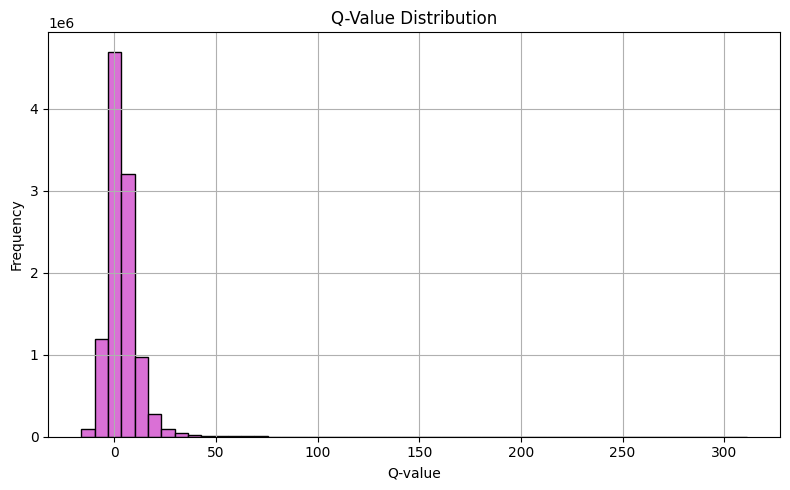

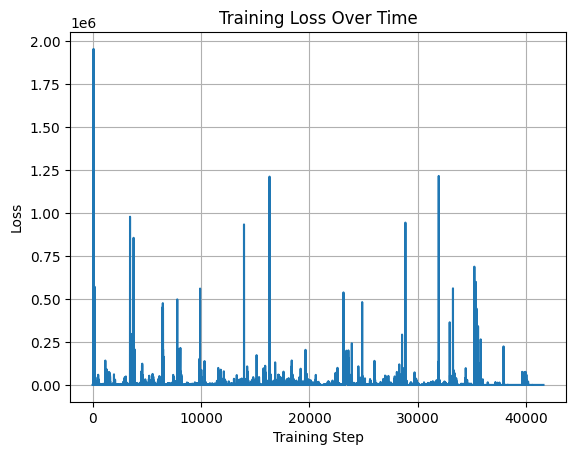

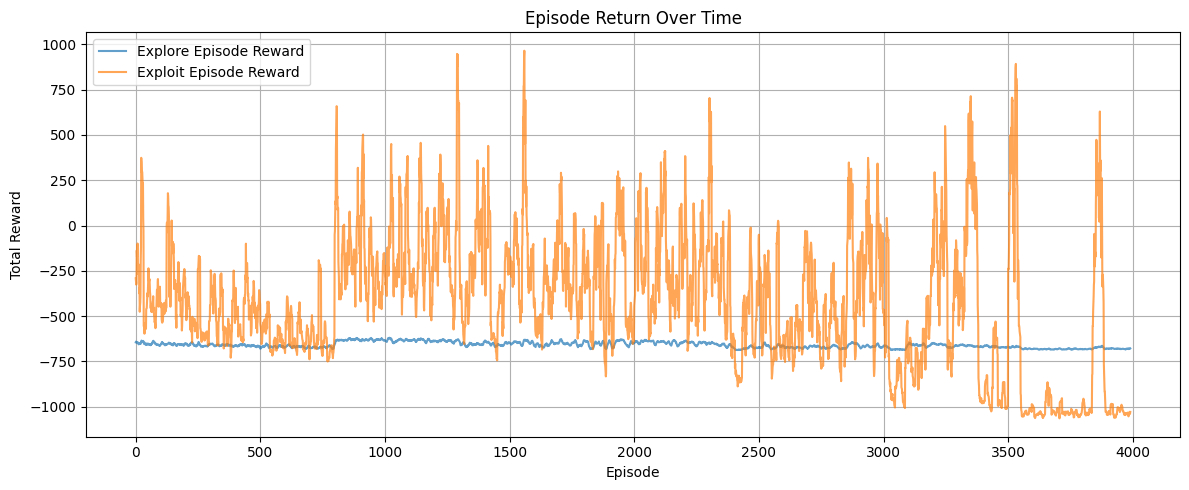

Run 1, Episodes: 4000
Run 1, Total steps 1363,Average Solve Score 1.6 
                  Explore Rewards sum: -670.0 Exploit Rewards sum: -460.0 
                  Success Rate in solving 0.15000000596046448 Episode: 200
Run 1, Total steps 1400,Average Solve Score 2.5 
                  Explore Rewards sum: -670.0 Exploit Rewards sum: -540.0 
                  Success Rate in solving 0.15000000596046448 Episode: 400
Run 1, Total steps 1423,Average Solve Score 2.7 
                  Explore Rewards sum: -670.0 Exploit Rewards sum: -560.0 
                  Success Rate in solving 0.10000000149011612 Episode: 600
Run 1, Total steps 1450,Average Solve Score nan 
                  Explore Rewards sum: -660.0 Exploit Rewards sum: -710.0 
                  Success Rate in solving 0.0 Episode: 800
Run 1, Total steps 1035,Average Solve Score 4.6 
                  Explore Rewards sum: -630.0 Exploit Rewards sum: 550.0 
                  Success Rate in solving 0.699999988079071 Episode: 1000
R

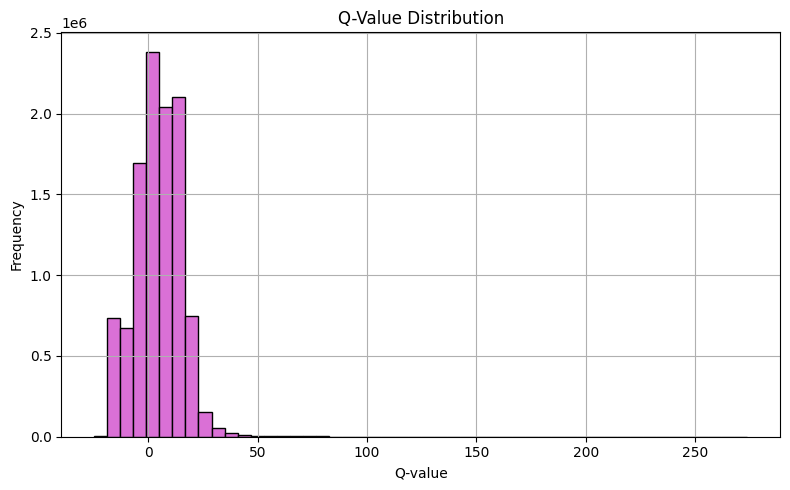

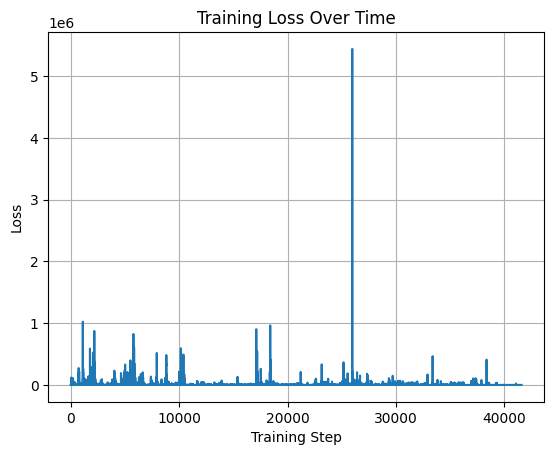

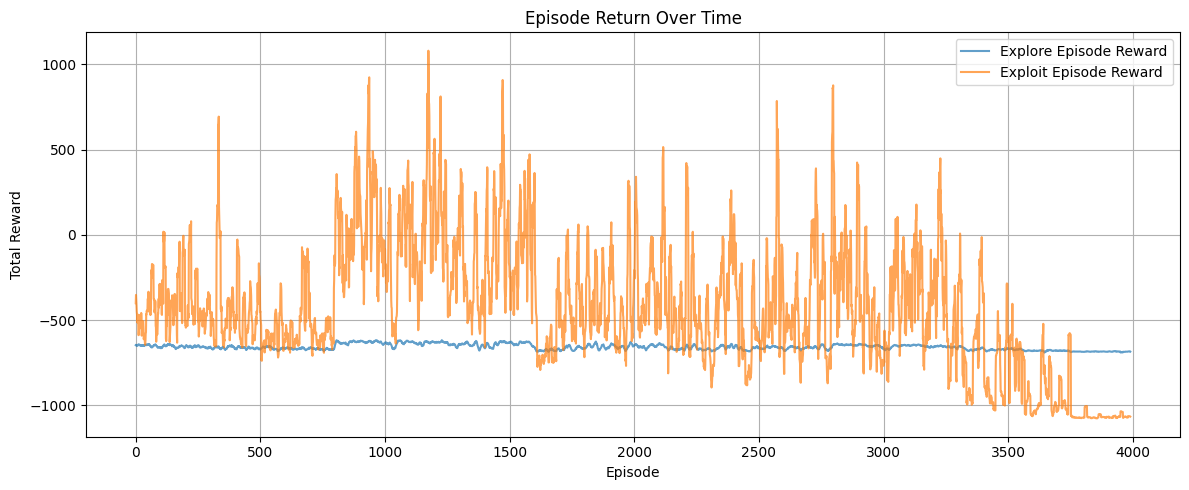

Run 2, Episodes: 4000
Run 2, Total steps 1223,Average Solve Score 5.0 
                  Explore Rewards sum: -640.0 Exploit Rewards sum: 250.0 
                  Success Rate in solving 0.550000011920929 Episode: 200
Run 2, Total steps 1459,Average Solve Score nan 
                  Explore Rewards sum: -650.0 Exploit Rewards sum: -580.0 
                  Success Rate in solving 0.0 Episode: 400
Run 2, Total steps 1251,Average Solve Score 3.0 
                  Explore Rewards sum: -650.0 Exploit Rewards sum: -6.0 
                  Success Rate in solving 0.4000000059604645 Episode: 600
Run 2, Total steps 1389,Average Solve Score 1.8 
                  Explore Rewards sum: -630.0 Exploit Rewards sum: -380.0 
                  Success Rate in solving 0.15000000596046448 Episode: 800
Run 2, Total steps 1454,Average Solve Score nan 
                  Explore Rewards sum: -650.0 Exploit Rewards sum: -620.0 
                  Success Rate in solving 0.0 Episode: 1000
Run 2, Total steps 1

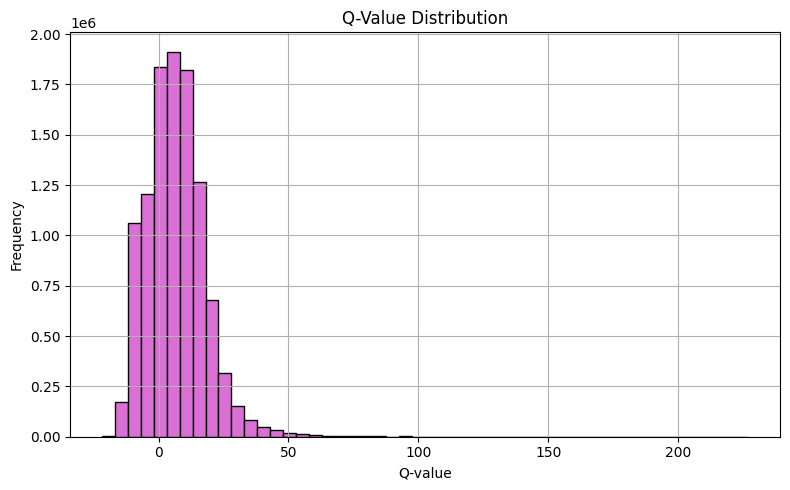

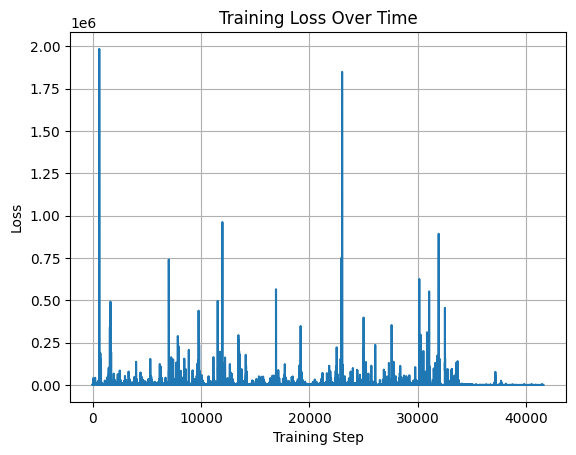

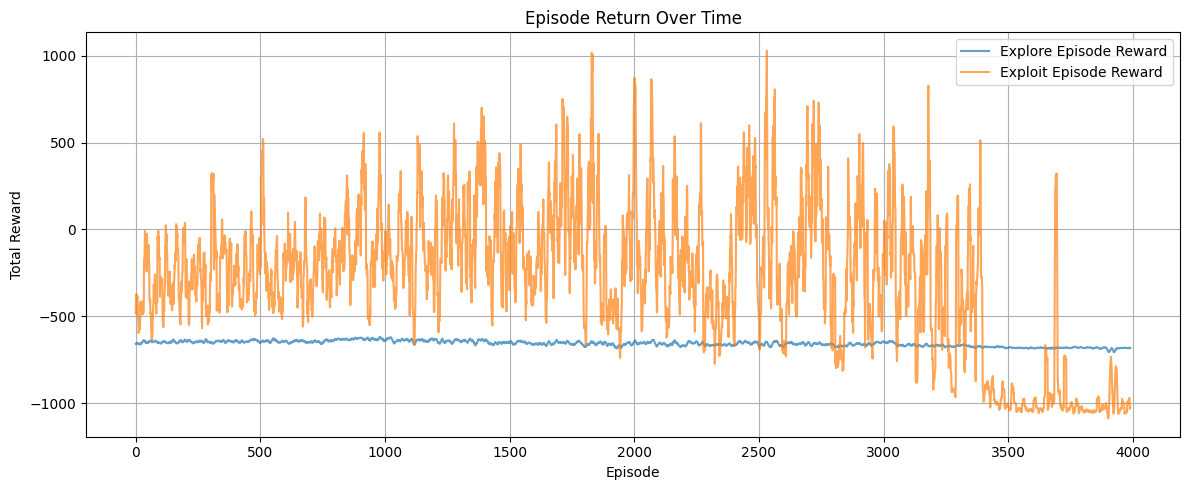

In [14]:
results = []
timestamp = datetime.datetime.now().strftime("%d-%m-_%H-%M")

number_of_iterations = 3
for i in range(number_of_iterations):
    results.append(run_single_experiment(hyperparams,timestamp ,run_id=i))
    plot_episode_returns(results[-1]["explore_rewards"], results[-1]["exploit_rewards"], 10)

    

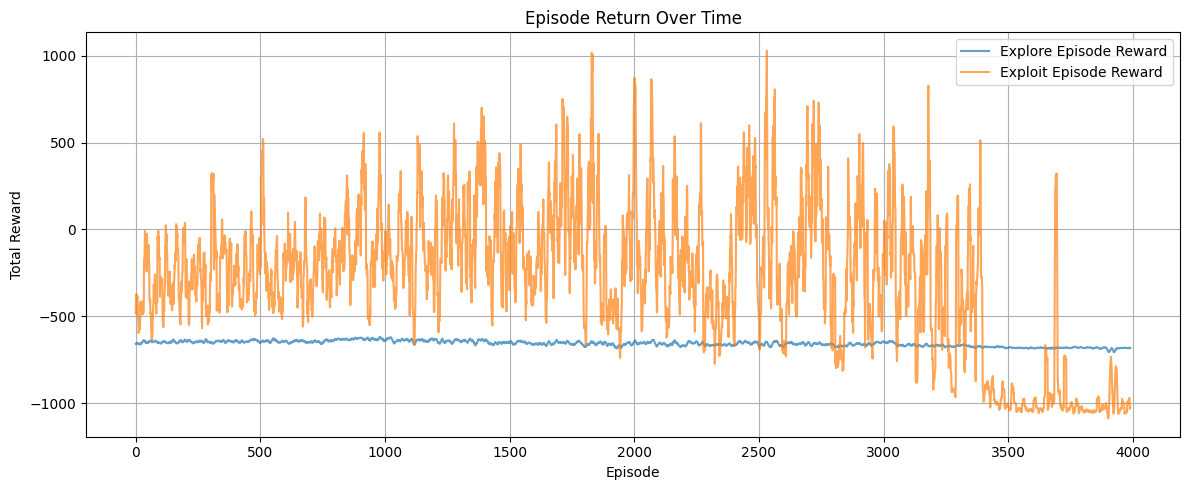

In [15]:
plot_episode_returns(results[-1]["explore_rewards"], results[-1]["exploit_rewards"], 10)


     ## Evaluation

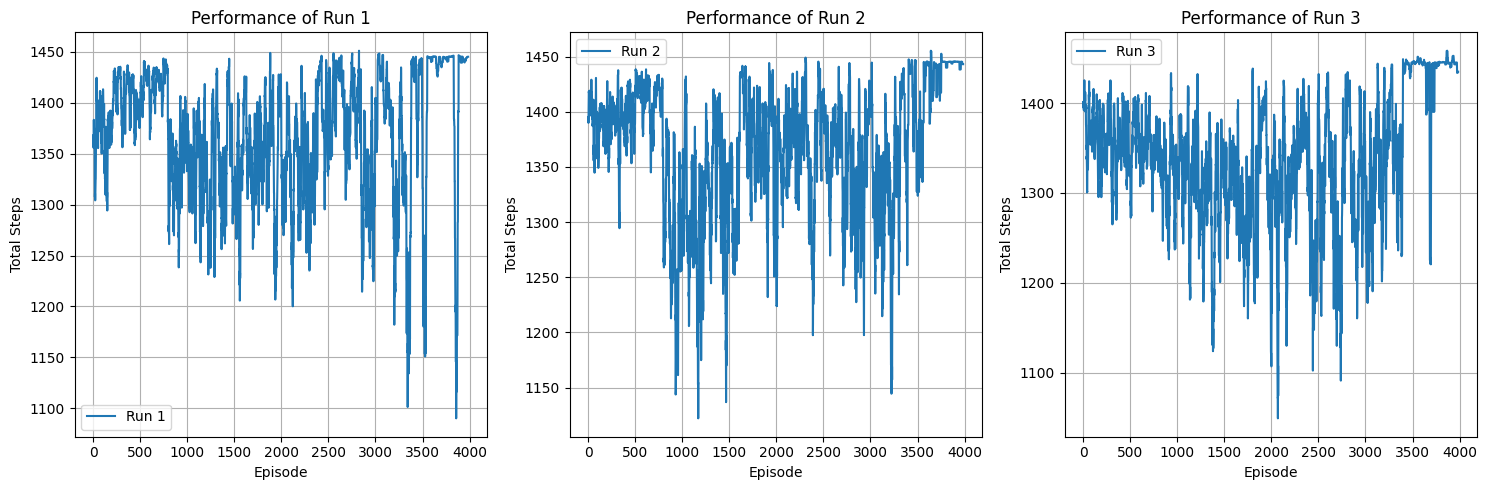

In [16]:
steps_nested  = [r["score"] for r in results]
steps = [score.total_steps for sublist in steps_nested for score in sublist] 


# Smoothing window size
window_size = 15  # You can adjust this window size for more or less smoothing

# Determine the number of subplots (rows x columns)
n_runs = len(steps_nested)
cols = 3  # Number of columns
rows = (n_runs // cols) + (n_runs % cols > 0)  # Calculate number of rows required

# Create a figure and axes for the subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each run in its own subplot
for i, run_scores in enumerate(steps_nested):
    steps = [s.total_steps for s in run_scores]
    
    # Apply moving average smoothing to the data
    smoothed_steps = moving_average(steps, window_size)
    
    # Select the current axis for this subplot
    ax = axes[i]
    
    # Plot the smoothed steps on the corresponding axis
    ax.plot(smoothed_steps, label=f"Run {i+1}")
    
    # Add labels and title
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total Steps")
    ax.set_title(f"Performance of Run {i+1}")
    ax.grid(True)
    ax.legend()

# Remove any empty subplots if the number of runs isn't a perfect multiple of columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# plt.figure(figsize=(10, 5))
# plt.hist(reward_log, bins=10, edgecolor='black')
# plt.title("Reward Distribution")
# plt.xlabel("Reward")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()
